## Summary

In [4]:
# TODO

### Data sources

Pull census data from 2010-2020

In [20]:
import urllib.request

url = "https://www2.census.gov/programs-surveys/popest/datasets/2010-2020/cities/SUB-EST2020_ALL.csv"
local_path = "population_2010_to_2020.csv"
urllib.request.urlretrieve(url, local_path)

('population_2010_to_2020.csv', <http.client.HTTPMessage at 0x7ff7783deb80>)

In [53]:
import pandas as pd

df = pd.read_csv(local_path, encoding="big5")

### Exploratory Data Analysis (Part 1)

In [46]:
df.head()

,SUMLEV,STATE,COUNTY,PLACE,COUSUB,CONCIT,PRIMGEO_FLAG,FUNCSTAT,NAME,STNAME,...,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018,POPESTIMATE2019,POPESTIMATE042020,POPESTIMATE2020
0,40,1,0,0,0,0,0,A,Alabama,Alabama,...,4816632,4831586,4843737,4854803,4866824,4877989,4891628,4907965,4920706,4921532
1,162,1,0,124,0,0,0,A,Abbeville city,Alabama,...,2645,2629,2610,2602,2587,2578,2565,2555,2555,2553
2,162,1,0,460,0,0,0,A,Adamsville city,Alabama,...,4453,4430,4399,4371,4335,4304,4285,4254,4224,4211
3,162,1,0,484,0,0,0,A,Addison town,Alabama,...,745,744,742,734,734,728,725,723,719,717
4,162,1,0,676,0,0,0,A,Akron town,Alabama,...,347,344,338,338,335,332,332,328,328,327


Let's look at the number of locations per state

In [48]:
df.groupby(["STNAME"]).size()

STNAME
Alabama                 1109
Alaska                   350
Arizona                  221
Arkansas                1173
California              1077
Colorado                 694
Connecticut              285
Delaware                 124
District of Columbia       4
Florida                  962
Georgia                 1453
Hawaii                     9
Idaho                    494
Illinois                7363
Indiana                 3796
Iowa                    2156
Kansas                  4137
Kentucky                1181
Louisiana                743
Maine                    629
Maryland                 364
Massachusetts            545
Michigan                3690
Minnesota               5456
Mississippi              781
Missouri                2789
Montana                  370
Nebraska                2013
Nevada                    65
New Hampshire            318
New Jersey              1580
New Mexico               281
New York                3414
North Carolina          1360
North D

### Feature Engineering (Part 1)

Most records are states, cities, or towns. Let's filter down to only those.

In [54]:
def is_city(row):
    return row["NAME"].endswith("city")

def is_town(row):
    return row["NAME"].endswith("town")

def is_state(row):
    return row["PLACE"] == 0

def get_location_type(row):
    if is_city(row):
        return "CITY"
    elif is_town(row):
        return "TOWN"
    elif is_state(row):
        return "STATE"
    else:
        return "UNKNOWN"

In [55]:
df["TYPE"] = df.apply(lambda row: get_location_type(row), axis=1)
filtered = df.apply(
    lambda row: row["TYPE"] != "UNKNOWN", 
    axis=1
)
df = df[filtered]

Let's clean up the city/town/state name by removing the type from the name

In [57]:
def clean_name(name):
    if name.endswith(" city"):
        return name[:-5]
    elif name.endswith(" town"):
        return name[:-5]
    else:
        return name

In [58]:
df["NAME"] = df.apply(
    lambda row: clean_name(row["NAME"]),
    axis=1
)

Convert to time series format

In [76]:
import datetime

ts_df = None
for year in range(2010, 2021):
    pop_estimate_col = f"POPESTIMATE{year}"
    year_subset = df[["NAME", "STNAME", "TYPE", pop_estimate_col]].copy()
    year_subset.rename(columns = {pop_estimate_col: "POPULATION_COUNT"}, inplace=True)
    year_subset["TIMESTAMP"] = datetime.datetime(year, 12, 31)
    if ts_df is None:
        ts_df = year_subset
    else:
        ts_df = pd.concat([ts_df, year_subset])

### Exploratory Data Analysis (Part 2)

In [77]:
ts_df.head()

,NAME,STNAME,TYPE,POPULATION_COUNT,TIMESTAMP
0,Alabama,Alabama,STATE,4785514,2010-12-31
1,Abbeville,Alabama,CITY,2699,2010-12-31
2,Adamsville,Alabama,CITY,4481,2010-12-31
3,Addison,Alabama,TOWN,751,2010-12-31
4,Akron,Alabama,TOWN,355,2010-12-31


<AxesSubplot:xlabel='TIMESTAMP'>

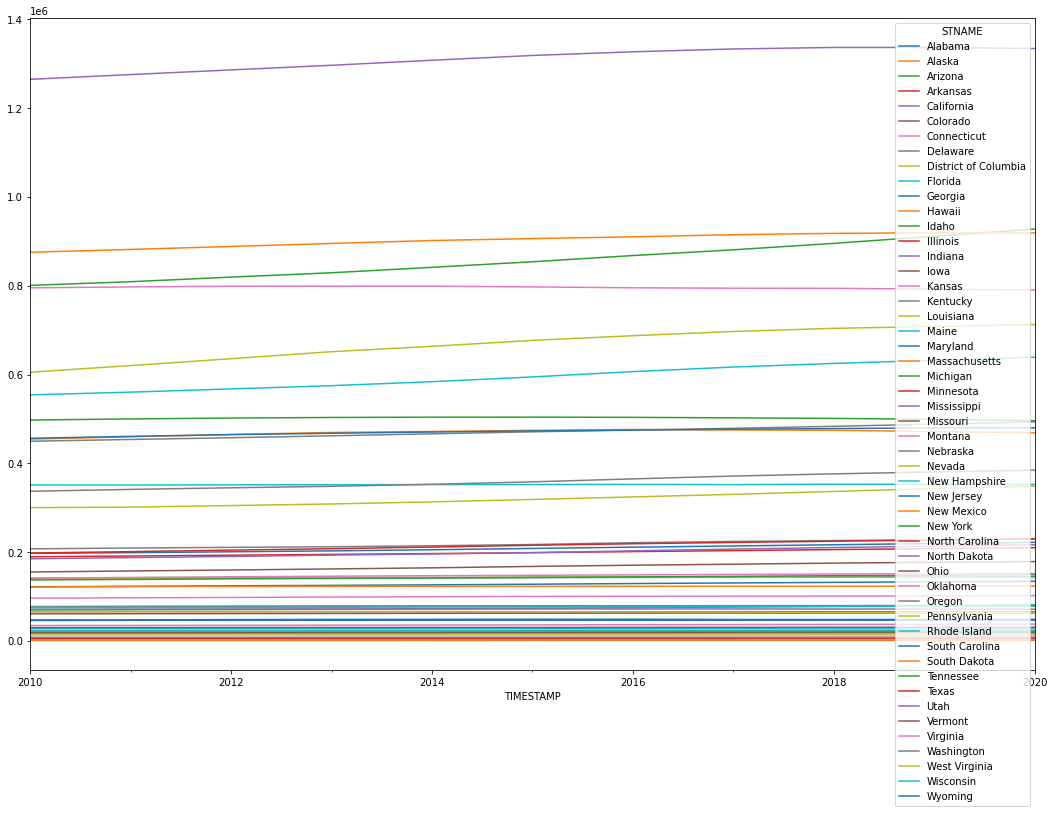

In [93]:
ts_df_states = ts_df.loc[ts_df["TYPE"] == "STATE"]
ts_df_states.pivot_table(index='TIMESTAMP', columns='STNAME', values='POPULATION_COUNT').plot(figsize=(18, 12))